# 第九次练习

学号：20179065 $ \qquad $ 班级序列号：170230 $ \qquad $ 姓名：董秩序

## NIPALS

>* (i) The outer loop iterate over components. 
>* (ii) The inner loop estimates the weights vectors. This can be done with two algo. 

>(a) the inner loop of the original NIPALS algo. or 
>(b) a SVD on residuals cross-covariance matrices


In [1]:
def _nipals_twoblocks_inner_loop(X, Y, max_iter=500, tol=1e-06,):  
    y_score = Y[:, [0]] 
    x_weights_old = 0
    ite = 1
    while True:
        # 1.1 Update u: the X weights
        # regress each X column on y_score
# w=X.T*Y[:,0]/||Y[:,0]||
        x_weights = np.dot(X.T, y_score) / np.dot(y_score.T, y_score) 
        # 1.2 Normalize u
# w=w/||w||
        x_weights /= np.sqrt(np.dot(x_weights.T, x_weights)) 
 # 1.3 Update x_score: the X latent scores
	   # t=X*w
        x_score = np.dot(X, x_weights) 
        # 2.1  regress each Y column on x_score
# q=Y*t/(t.T*t)
        y_weights = np.dot(Y.T, x_score) / np.dot(x_score.T, x_score) 

        # 2.2 Update y_score: the Y latent scores
	    # u=Y*q/(q.T,q)
        y_score = np.dot(Y, y_weights) / np.dot(y_weights.T, y_weights) 
        x_weights_diff = x_weights - x_weights_old
        if np.dot(x_weights_diff.T, x_weights_diff) < tol :
            break

        if ite == max_iter:
            warnings.warn('Maximum number of iterations reached')
            break
        x_weights_old = x_weights
        ite += 1

    return x_weights, y_weights 

In [2]:
def _center_xy(X, Y):      

    # center
    x_mean = X.mean(axis=0)
    X_center = np.subtract(X, x_mean)
    y_mean = Y.mean(axis=0)
    Y_center = np.subtract(Y, y_mean)

    return X_center, Y_center, x_mean, y_mean


## NIPALS

In [3]:
class _NIPALS():      
    def __init__(self, n_components, max_iter=500, tol=1e-06, copy=True):
        self.n_components = n_components 
        self.max_iter = max_iter         
        self.tol = tol
        self.copy = copy

    def fit(self, X, Y, n_components):    
        n = X.shape[0]
        p = X.shape[1]
        q = Y.shape[1]

        if n != Y.shape[0]:    
                'Incompatible shapes: X has %s samples, while Y '
                'has %s' % (X.shape[0], Y.shape[0])
        if self.n_components < 1 or self.n_components > p: 
            raise ValueError('invalid number of components')

        Xcenter, Ycenter, self.x_mean_, self.y_mean_ = _center_xy(X, Y) 
        # Residuals (deflated) matrices
        Xk = Xcenter
        Yk = Ycenter
        # Results matrices
        self.x_scores_ = np.zeros((n, self.n_components))  
        self.y_scores_ = np.zeros((n, self.n_components))  
        self.x_weights_ = np.zeros((p, self.n_components)) 
        self.y_weights_ = np.zeros((q, self.n_components)) 
        self.x_loadings_ = np.zeros((p, self.n_components)) 
        self.y_loadings_ = np.zeros((q, self.n_components))
 
        # NIPALS algo: outer loop, over components
        for k in range(self.n_components):
            x_weights, y_weights = _nipals_twoblocks_inner_loop(
                    X=Xk, Y=Yk, max_iter=self.max_iter, tol=self.tol,)
            # compute scores
            x_scores = np.dot(Xk, x_weights) 
            y_ss = np.dot(y_weights.T, y_weights)
            y_scores = np.dot(Yk, y_weights) / y_ss  
            x_loadings = np.dot(Xk.T, x_scores) / np.dot(x_scores.T, x_scores)
            # - substract rank-one approximations to obtain remainder matrix
            Xk -= np.dot(x_scores, x_loadings.T)

            y_loadings = (np.dot(Yk.T, x_scores) / np.dot(x_scores.T, x_scores))
            Yk -= np.dot(x_scores, y_loadings.T)
            self.x_scores_[:, k] = x_scores.ravel()  # T    
            self.y_scores_[:, k] = y_scores.ravel()  # U   
            self.x_weights_[:, k] = x_weights.ravel()  # W   
            self.y_weights_[:, k] = y_weights.ravel()  # C   
            self.x_loadings_[:, k] = x_loadings.ravel()  # P 
            self.y_loadings_[:, k] = y_loadings.ravel()  # Q 
           
        lists_coefs = []              
        for i in range(n_components):   
            self.x_rotations_ = np.dot(self.x_weights_[:, :i + 1], 
                                       np.linalg.inv(np.dot(self.x_loadings_[:, :i + 1].T, self.x_weights_[:, :i + 1])))
            self.coefs = np.dot(self.x_rotations_, self.y_loadings_[:, :i + 1].T)
             
            lists_coefs.append(self.coefs)
        
        return lists_coefs 

    def predict(self, x_test, coefs_B, xtr_mean, ytr_mean):

        xte_center = np.subtract(x_test, xtr_mean)
        y_pre = np.dot(xte_center, coefs_B)
        y_predict = np.add(y_pre, ytr_mean)          
 
        return y_predict


## cross_validation

In [4]:
import numpy as np
from sklearn import cross_validation
#from NIPALS import _NIPALS

class Cross_Validation():  # Variable initialization

    def __init__(self, x, y, n_fold, max_components):
        self.x = x
        self.y = y 
        self.n = x.shape[0]
        self.n_fold = n_fold
        self.max_components = max_components

    def cv(self):  # Divide training sets and test sets
        kf = cross_validation.KFold(self.n, self.n_fold)
        x_train = []
        y_train = []
        x_test = [] 
        y_test = []

        for train_index, test_index in kf:
            xtr, ytr = self.x[train_index], self.y[train_index]
            xte, yte = self.x[test_index], self.y[test_index]
            x_train.append(xtr)
            y_train.append(ytr)
            x_test.append(xte)
            y_test.append(yte)

        return x_train, x_test, y_train, y_test

    def predict_cv(self):
        x_train, x_test, y_train, y_test = self.cv()
        y_allPredict = np.ones((1, self.max_components))
        pls = _NIPALS(self.max_components)

        for i in range(self.n_fold):
            y_predict = np.zeros((y_test[i].shape[0], self.max_components))
            x_trainMean = np.mean(x_train[i], axis=0)
            y_trainMean = np.mean(y_train[i], axis=0)
            x_testCenter = np.subtract(x_test[i], x_trainMean)
            list_coef_B = pls.fit(x_train[i], y_train[i], self.max_components)
            for j in range(self.max_components):
                y_pre = np.dot(x_testCenter, list_coef_B[j])
                y_pre = y_pre + y_trainMean
                y_predict[:, j] = y_pre.ravel()
            y_allPredict = np.vstack((y_allPredict, y_predict))
        y_allPredict = y_allPredict[1:]
                                                           
        return y_allPredict, self.y

    def mse_cv(self, y_allPredict, y_measure):

        PRESS = np.square(np.subtract(y_allPredict, y_measure))
        all_PRESS = np.sum(PRESS, axis=0)

        RMSECV = np.sqrt(all_PRESS / self.n)
        min_RMSECV = min(RMSECV)
        comp_array = RMSECV.argsort()
        comp_best = comp_array[0] + 1  #!!!!!

        return RMSECV, min_RMSECV, comp_best


D:\Users\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## PLS

In [5]:
#from cross_validation import Cross_Validation
#from NIPALS import _NIPALS
#import numpy as np
 
class PLS():
    def __init__(self, x_train, y_train, x_test, y_test, n_fold=10, max_components=10):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.n_fold = n_fold
        self.max_components = max_components
                                            
    def pls(self):
        # Select the optimal principal component number
        pls_cv = Cross_Validation(self.x_train, self.y_train, self.n_fold, self.max_components)
        y_allPredict, y_measure = pls_cv.predict_cv()
        RMSECV, min_RMSECV, comp_best = pls_cv.mse_cv(y_allPredict, y_measure)
        #  Modeling by optimal principal component number
        pls = _NIPALS(comp_best)
        List_coef_B = pls.fit(self.x_train, self.y_train, comp_best)
        coef_B = List_coef_B[comp_best - 1] 
        
        x_trainMean = np.mean(self.x_train, axis=0)
        y_trainMean = np.mean(self.y_train, axis=0)
        y_trainPredict = pls.predict(self.x_train, coef_B, x_trainMean, y_trainMean)
        # compute RMSEC
        press = np.square(np.subtract(self.y_train, y_trainPredict))
        all_press = np.sum(press, axis=0)
        RMSEC = np.sqrt(all_press / self.x_train.shape[0])
         # compute RMSEP
        y_predict = pls.predict(self.x_test, coef_B, x_trainMean, y_trainMean)
        press = np.square(np.subtract(self.y_test, y_predict))
        all_press = np.sum(press, axis=0)
        RMSEP = np.sqrt(all_press / self.x_test.shape[0])
        
        return RMSECV, min_RMSECV, comp_best, RMSEC, RMSEP, y_trainPredict, y_predict

## 可视化

In [6]:
import matplotlib.pyplot as plt
#实际值与有关预测值进行比较
def draws_pre_pharm(Y_test, Y_predict, y_trainPredict, y_train):
 
    plt.figure(figsize=(8, 8), facecolor='white')
    plt.subplot(221) 
    plt.title('oil')
    plt.plot([min(y_train[0]), max(y_train[0])], [min(y_train[0]), max(y_train[0])], 'black', label='y=x')
    plt.scatter(y_train[0], y_trainPredict[0], s=20, c='r', marker='o', label='calibration set')
    plt.scatter(Y_test[0], Y_predict[0], s=30, c='b', marker='o', label='test set')
    plt.xlabel('Measured value')
    plt.ylabel(' Predicted value')
    

    plt.subplot(222)
    plt.title('starch') 
    plt.plot([min(y_train[1]), max(y_train[1])], [min(y_train[1]), max(y_train[1])], 'black', label='y=x')
    plt.scatter(y_train[1], y_trainPredict[1], s=20, c='r', marker='o', label='calibration set')
    plt.scatter(Y_test[1], Y_predict[1], s=30, c='b', marker='o', label='test set')
    plt.xlabel('Measured value')
    plt.ylabel(' Predicted value')

    
    plt.subplot(223) 
    plt.title('pro')
    plt.plot([min(y_train[2]), max(y_train[2])], [min(y_train[2]), max(y_train[2])], 'black', label='y=x')
    plt.scatter(y_train[2], y_trainPredict[2], s=20, c='r', marker='o', label='calibration set')
    plt.scatter(Y_test[2], Y_predict[2], s=30, c='b', marker='o', label='test set')
    plt.xlabel('Measured value')
    plt.ylabel(' Predicted value')
    
    
    plt.subplot(224) 
    plt.title('water')
    plt.plot([min(y_train[3]), max(y_train[3])], [min(y_train[3]), max(y_train[3])], 'black', label='y=x')
    plt.scatter(y_train[3], y_trainPredict[3], s=20, c='r', marker='o', label='calibration set')
    plt.scatter(Y_test[3], Y_predict[3], s=30, c='b', marker='o', label='test set')
    plt.xlabel('Measured value')
    plt.ylabel(' Predicted value')
   
    plt.tight_layout()
    plt.show()

#从PLS模型中选择最佳潜在变量数的过程
#'oil', 'starch', 'pro', 'water'
def rmsecv_comp_line_pharm(max_components, rmsecv_list):
    
    plt.figure(figsize=(8, 8), facecolor='white')
    plt.subplot(221) 
    plt.title('oil')
    plt.plot(range(1, max_components + 1), rmsecv_list[0], '-o')
    plt.xlabel('num_components')
    plt.ylabel('RMSECV')

    plt.subplot(222)
    plt.title('starch') 
    plt.plot(range(1, max_components + 1), rmsecv_list[1], '-o')
    plt.xlabel('num_components')
    plt.ylabel('RMSECV')
    
    plt.subplot(223) 
    plt.title('pro')
    plt.plot(range(1, max_components + 1), rmsecv_list[2], '-o')
    plt.xlabel('num_components')
    plt.ylabel('RMSECV')   
    
    plt.subplot(224) 
    plt.title('water')
    plt.plot(range(1, max_components + 1), rmsecv_list[3], '-o')
    plt.xlabel('num_components')
    plt.ylabel('RMSECV')
   
    plt.tight_layout()
    plt.show()


## Example application

m5 oil
RMSECV [ 0.17629096  0.16681719  0.13940448  0.10102171  0.08829704  0.08336134
  0.07462155  0.07482885  0.06846579]
min_RMSECV 0.0684657921342
comp_best 9
RMSEP: [ 0.06048119]


m5 starch
RMSECV [ 0.84287271  0.81953334  0.67030555  0.56394261  0.49403892  0.43169335
  0.35344     0.30304482  0.3191829 ]
min_RMSECV 0.303044815403
comp_best 8
RMSEP: [ 0.28423622]


m5 pro
RMSECV [ 0.47366436  0.45083695  0.32488889  0.26400453  0.20601404  0.18499061
  0.15457974  0.14524952  0.13223247]
min_RMSECV 0.132232472901
comp_best 9
RMSEP: [ 0.1028038]


m5 water
RMSECV [ 0.30269952  0.25737487  0.18808281  0.072574    0.05098757  0.02961022
  0.02774756  0.02554763  0.02129437]
min_RMSECV 0.0212943734628
comp_best 9
RMSEP: [ 0.0238987]


The selection process of the optimal latent variables number from PLS model about the  m5


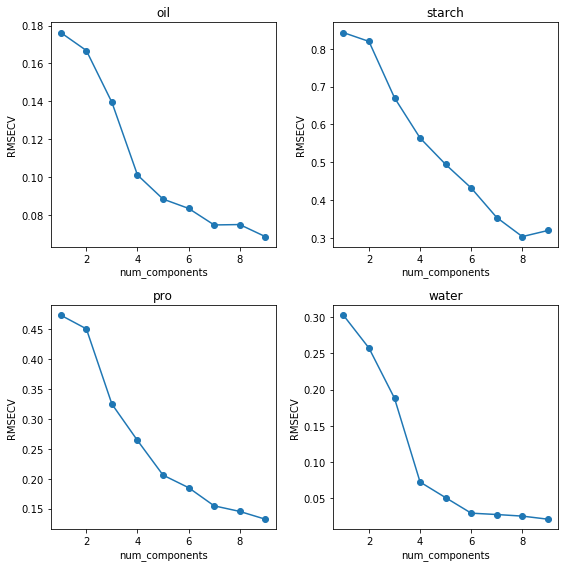

The actual value compared with the predicted value about the  m5  instrument.


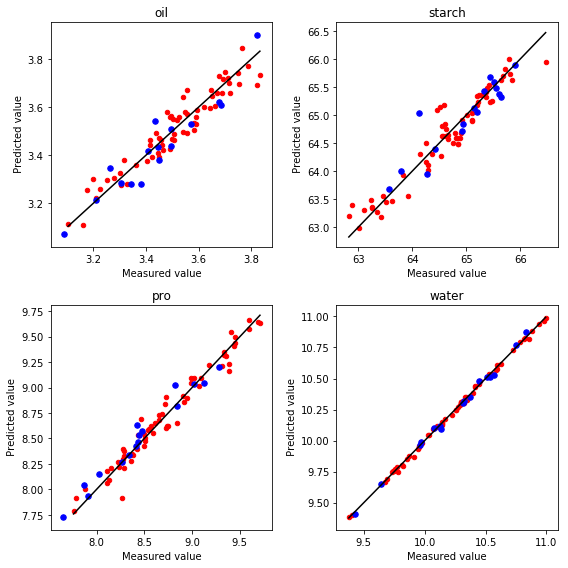

mp5 oil
RMSECV [ 0.17305513  0.15916037  0.13384274  0.11755294  0.10892071  0.10263416
  0.10078927  0.10102846  0.10654359]
min_RMSECV 0.100789270821
comp_best 7
RMSEP: [ 0.07055259]


mp5 starch
RMSECV [ 0.84306041  0.81294549  0.59268484  0.53894313  0.52135504  0.447189
  0.41362547  0.38701688  0.37524013]
min_RMSECV 0.375240126108
comp_best 9
RMSEP: [ 0.34004861]


mp5 pro
RMSECV [ 0.47075969  0.44586737  0.27886217  0.2396058   0.21453646  0.18945987
  0.17352615  0.1524408   0.14797374]
min_RMSECV 0.147973741433
comp_best 9
RMSEP: [ 0.16101876]


mp5 water
RMSECV [ 0.30187712  0.26307321  0.20904577  0.20171082  0.18436796  0.16431467
  0.15284302  0.15286832  0.14095779]
min_RMSECV 0.14095778542
comp_best 9
RMSEP: [ 0.13670961]


The selection process of the optimal latent variables number from PLS model about the  mp5


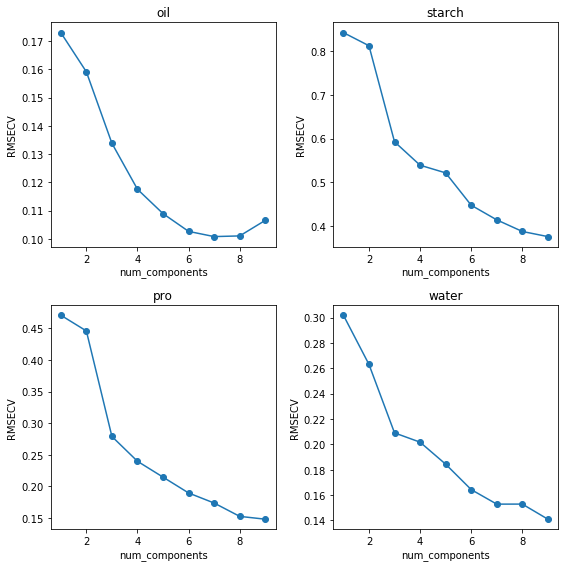

The actual value compared with the predicted value about the  mp5  instrument.


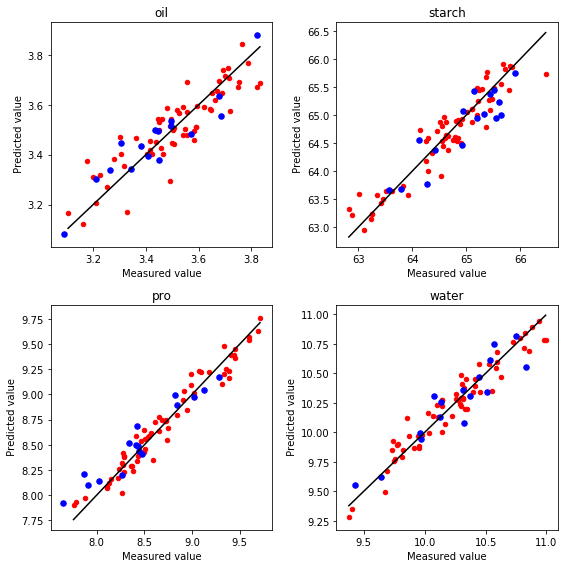

mp6 oil
RMSECV [ 0.17331899  0.16023794  0.13914462  0.12570084  0.11702873  0.11085178
  0.10308057  0.10376007  0.10706935]
min_RMSECV 0.103080572518
comp_best 7
RMSEP: [ 0.07013598]


mp6 starch
RMSECV [ 0.84374778  0.78911515  0.62904305  0.54680608  0.51579505  0.46842379
  0.41528782  0.37768861  0.35826078]
min_RMSECV 0.358260775913
comp_best 9
RMSEP: [ 0.31259899]


mp6 pro
RMSECV [ 0.46988772  0.43916345  0.29678658  0.23660799  0.22643758  0.20091117
  0.18487403  0.15813341  0.14781656]
min_RMSECV 0.147816560997
comp_best 9
RMSEP: [ 0.14034578]


mp6 water
RMSECV [ 0.3000477   0.25664927  0.2217029   0.21699924  0.20520017  0.19186095
  0.16315016  0.1640678   0.16602371]
min_RMSECV 0.163150159884
comp_best 7
RMSEP: [ 0.15609604]


The selection process of the optimal latent variables number from PLS model about the  mp6


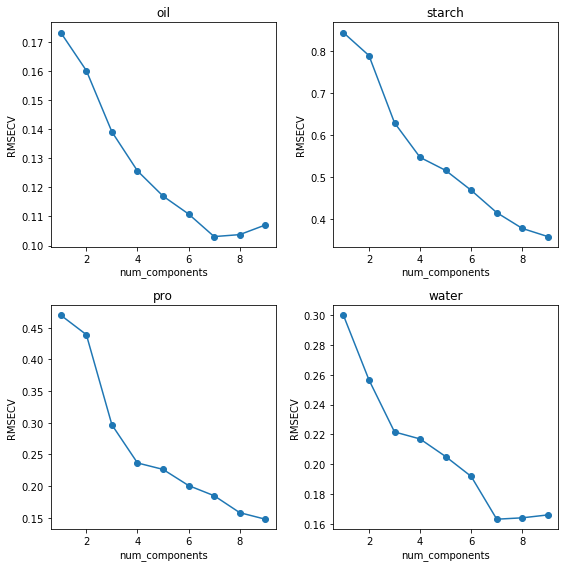

The actual value compared with the predicted value about the  mp6  instrument.


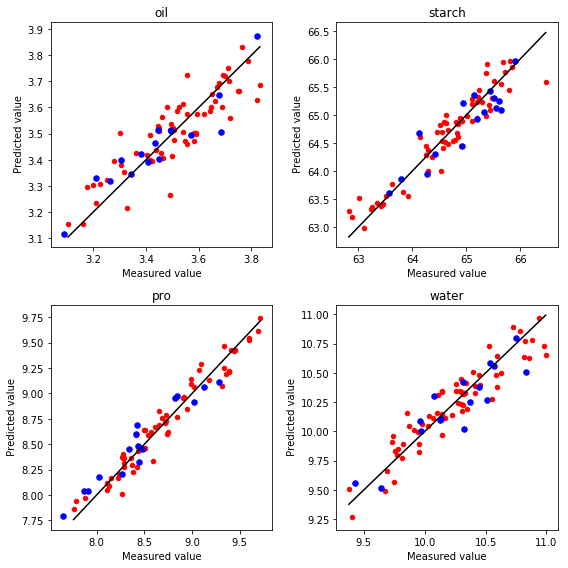

In [12]:
#from sklearn.cross_validation import train_test_split #No module named sklearn.cross_validation

from sklearn.model_selection import train_test_split
from scipy.io.matlab.mio import loadmat
#from PLS.PLS import PLS

if __name__ == '__main__':
    
    fname = loadmat('E:\Documents\DAY\cornmat.mat')
    #print fname.keys()
    X = ('m5', 'mp5','mp6')
    Y = ('oil', 'starch', 'pro', 'water')
    for a in X: #对每个instrument
        rmsecv_list = []
        
        Y_test = []
        Y_predict = []
        Y_trainPredict = []
        Y_train = []

        for b in Y:
            x = fname[a]
            y = fname[b][:, 0:1]
            #print x.shape, y.shape

            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)  
            demo = PLS(x_train, y_train, x_test, y_test, n_fold=10, max_components=9)
            RMSECV, min_RMSECV, comp_best, RMSEC, RMSEP, y_trainPredict, y_predict = demo.pls()
            rmsecv_list.append(RMSECV)
                       
            Y_test.append(np.squeeze(y_test).tolist())#数组降维并转换为list
            Y_predict.append(np.squeeze(y_predict).tolist())
            Y_trainPredict.append(np.squeeze(y_trainPredict).tolist())
            Y_train.append(np.squeeze(y_train).tolist())
            
           
            print a,b
            print 'RMSECV', RMSECV
            print 'min_RMSECV', min_RMSECV   
            print  'comp_best', comp_best
            print 'RMSEP:', RMSEP
            print '\n'
        
        print "The selection process of the optimal latent variables number from PLS model about the ",a
        rmsecv_comp_line_pharm(9, rmsecv_list)
        print "The actual value compared with the predicted value about the ",a," instrument."
        draws_pre_pharm(Y_test, Y_predict, Y_trainPredict, Y_train)
            



### 遇到的问题

* 书里代码为python2，直接在电脑安装2版本会和3冲突，包导入繁琐，故直接在anaconda里面建立虚拟的python环境，方便包的管理。

* python2没能直接导入sklearn包，需要安装scikit-learn

* from sklearn.cross_validation import train_test_split报错，cross_validatio这个包早就不在使用了，划分到了model_selection这个包中

* 对数据集的内容不熟悉，对于该数据集导入之后如何处理不明白。经过尝试发现文件导入后形成一个字典，直接取字典中的键来使用数据集。

* 为了方便完整地出结果，需要在调用时增加循环，而为了画图的需要，在外层循环添加列表，以存储画图时需要传入的参数

* 画图的问题：书上的可视化函数画成一个三列两行的大图，但所需数据集的元素只有四个，因此只需要两行两列，需要修改画图的函数

* 画图时在列表中取出Reference values，故对numpy数组y_test, y_predict, y_trainPredict, y_train降维，然后转为列表形式，保存到外层循环的列表中